## HETEROSCEDASTIC MDN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
%matplotlib inline
print ("PACKAGES LOADED")

PACKAGES LOADED


## SET TRAINING DATA

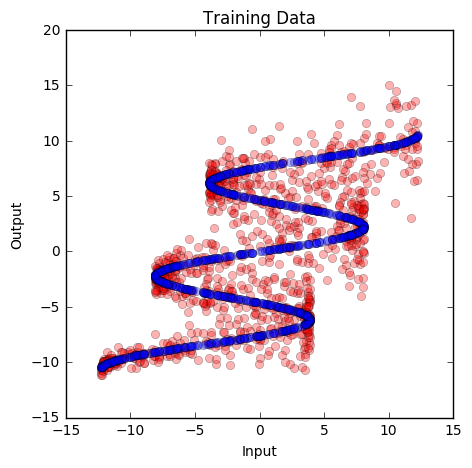

In [2]:
NSAMPLE = 1000
r_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
y_data = np.copy(r_data)
n_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
x_data = np.float32(np.sin(0.75*y_data)*7.0 + y_data*0.5 + n_data*0.01)
for i in range(NSAMPLE): # ADD NOISE 
    y_data[i] = r_data[i] + 0.1*(x_data[i]+15)*n_data[i]
# PLOT
plt.figure(figsize=(5, 5))
plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.plot(x_data, r_data, 'bo', alpha=0.3)
plt.title("Training Data")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

## MIXTURE DENSITY NETWORK

In [3]:
NHIDDEN = 50
STDEV   = 0.1
KMIX    = 20 # NUMBER OF MIXTURES
NOUT    = KMIX * 3 # PI / MU / STD

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wmdn = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32)),
    "l2_mds": tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32)),
    "l2_err": tf.Variable(tf.random_normal([NHIDDEN,1], stddev=STDEV, dtype=tf.float32))
}
bmdn = {
    "l1": tf.Variable(tf.zeros([1,NHIDDEN], dtype=tf.float32)),
    "l2_mds": tf.Variable(tf.random_uniform([1,NOUT], minval=-10, maxval=10, dtype=tf.float32)),
    "l2_err": tf.Variable(tf.zeros([1,1], dtype=tf.float32))
}

def mdn(_x, _W, _b):
    sig_gain = 1
    _l1  = tf.nn.tanh(tf.matmul(_x, _W['l1']) + _b['l1'])
    _out_mds = tf.matmul(_l1, _W['l2_mds']) + _b['l2_mds']
    _out_err_sigma_hat = tf.matmul(_l1, _W['l2_err']) + _b['l2_err']
    # CONVERT OUTPUT (PI / MU / SIGMA)
    _out_pi_hat, _out_sigma_hat, _out_mu = tf.split(_out_mds, 3, 1)
    _out_pi_hat = tf.exp(_out_pi_hat - tf.reduce_max(_out_pi_hat, 1, keep_dims=True))
    _nor_pi = tf.reciprocal(tf.reduce_sum(_out_pi_hat, 1, keep_dims=True))
    _out_pi = tf.multiply(_nor_pi, _out_pi_hat)
    _out_sigma = sig_gain*tf.sigmoid(_out_sigma_hat)
    # CONVERT NOISE MODEL (SIGMA)
    _out_err_sigma = sig_gain*tf.sigmoid(_out_err_sigma_hat)
    return _out_pi, _out_sigma, _out_mu, _out_err_sigma
out_pi, out_sigma, out_mu, out_err_sigma = mdn(x, Wmdn, bmdn)
print ("MIXTURE DENSITY NETOWRK READY")

MIXTURE DENSITY NETOWRK READY


## SAMPLING FUNCTION

In [4]:
def get_pi_idx(_th, _pdf):
    accumulate = 0
    _pdf = _pdf + 0.0001
    _pdf = _pdf / np.sum(_pdf)
    for i in range(0, _pdf.size):
        accumulate += _pdf[i]
        if (accumulate >= _th):
            return i
    print ("error with sampling ensemble")
    return -1
def sample_gmm(_out_pi, _out_mu, _out_sigma, _M):
    NTEST  = _out_pi.shape[0]
    result = np.zeros((NTEST, _M))
    randns = np.random.randn(NTEST, _M) 
    for j in range(0, _M):
        for i in range(0, NTEST):
            idx = get_pi_idx(np.random.rand(), _out_pi[i])
            mu  = _out_mu[i, idx]
            std = _out_sigma[i, idx]
            result[i, j] = mu + randns[i, j]*std
    return result
def sample_hgmm(_out_pi, _out_mu, _out_sigma, _out_err_sigma, _M):
    NTEST  = _out_pi.shape[0]
    result = np.zeros((NTEST, _M))
    randns = np.random.randn(NTEST, _M) 
    randns2 = np.random.randn(NTEST, _M) 
    for i in range(0, NTEST):
        for j in range(0, _M):
            idx = get_pi_idx(np.random.rand(), _out_pi[i])
            mu  = _out_mu[i, idx]
            std = _out_sigma[i, idx]
            err_std = _out_err_sigma[i]
            result[i, j] = mu + randns[i, j]*std + randns2[i, j]*err_std
    return result
print ("SAMPLING FUNCTION READY")

SAMPLING FUNCTION READY


## TRAIN

START OPTIMIZATION (NSAMPLE: 1000 / NITER: 10)


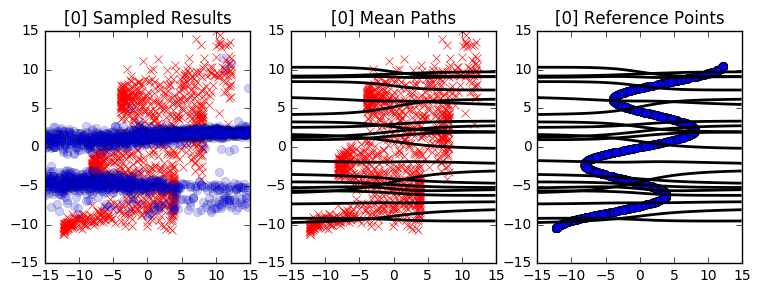

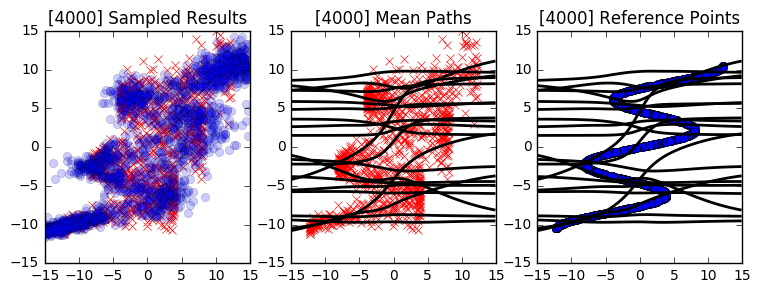

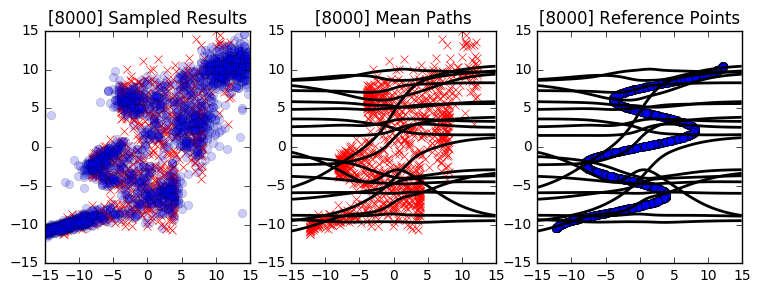

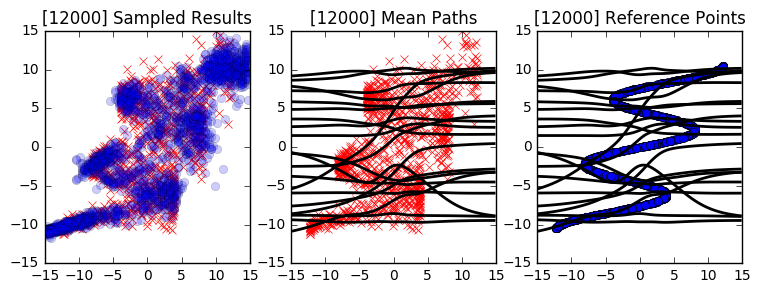

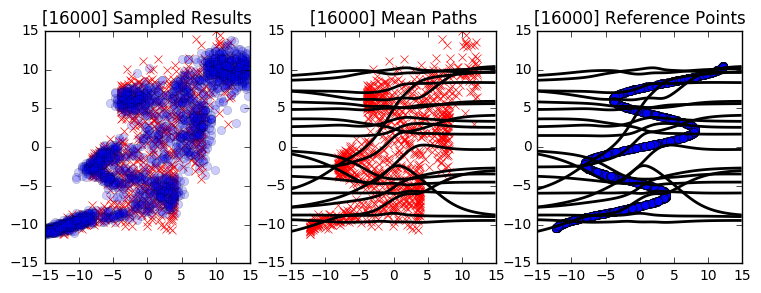

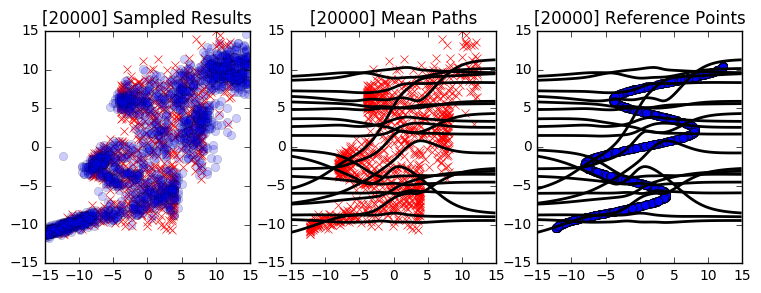

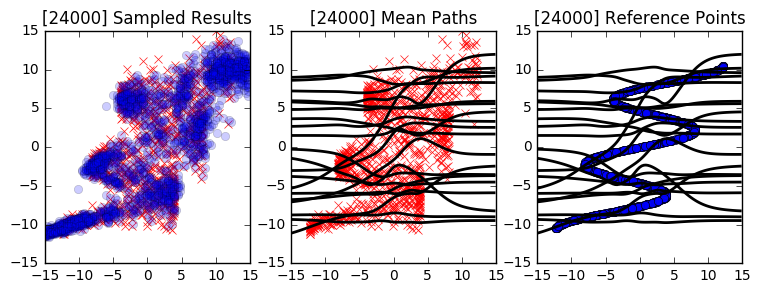

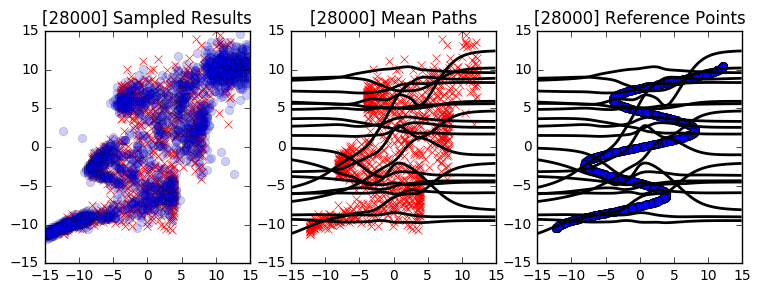

OPTIMIZATION FINISHED


In [5]:
pi = math.pi
# UNIVARIATE GAUSSIAN MODEL
def tf_normal(_y, _mu, _sigma):
    _result = (_y-_mu)/_sigma
    _result = -tf.square(_result)/2
    _result = tf.exp(_result)/(math.sqrt(2*pi)*_sigma)    
    return _result
# GAUSSIAN MIXTURE MODEL
def gmm(_y, _out_pi, _out_sigma, _out_mu):
    _probs  = tf_normal(_y, _out_mu, _out_sigma)
    _result = tf.multiply(_out_pi, _probs)
    _result = tf.reduce_sum(_result, 1, keep_dims=True)
    return tf.reduce_mean(-tf.log(_result))
# HETEROSCEDASTIC GAUSSIAN MIXTURE MODEL
def hgmm(_y, _out_pi, _out_sigma, _out_mu, _out_err_sig):
    _probs  = tf_normal(_y, _out_mu, _out_sigma+_out_err_sig)
    _result = tf.multiply(_out_pi, _probs)
    _result = tf.reduce_sum(_result, 1, keep_dims=True)
    return tf.reduce_mean(-tf.log(_result))

# SET LOSS AND OPTIMIZER
loss = hgmm(y, out_pi, out_sigma, out_mu, out_err_sigma)
optm = tf.train.AdamOptimizer(learning_rate=0.001
            , beta1=0.9, beta2=0.999, epsilon=0.1).minimize(loss)

# OPEN SESSION
tf.set_random_seed(0)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NEPOCH = 30000
NBATCH = 100
NITER  = int(NSAMPLE/NBATCH)
losses = np.zeros(NEPOCH) # store the training progress here.
print ("START OPTIMIZATION (NSAMPLE: %d / NITER: %d)" 
       % (NSAMPLE, NITER))
for epoch in range(NEPOCH): # FOR ALL EPOCH
    randpermlist = np.random.permutation(NSAMPLE)
    sumloss = 0
    for i in range(NITER): # FOR ALL ITERATION
        randidx = randpermlist[i*NBATCH:min((i+1)*NBATCH, NSAMPLE-1)]
        batch_xs = x_data[randidx]
        batch_ys = y_data[randidx]
        feeds = {x: batch_xs, y: batch_ys}
        sess.run(optm, feed_dict=feeds)
        sumloss += sess.run(loss, feed_dict=feeds)
    avgloss = sumloss / NITER
    losses[epoch] = avgloss
    if (epoch%4000) == 0:
        x_sample = np.float32(np.arange(-15, 15, 0.3)).reshape(-1, 1)
        out_pi_test, out_sigma_test, out_mu_test, out_err_sigma_test \
            = sess.run([out_pi, out_sigma, out_mu, out_err_sigma]
                       , feed_dict={x: x_sample})
        y_test = sample_hgmm(out_pi_test, out_mu_test, out_sigma_test
                             , out_err_sigma_test, KMIX)
        # PLOT
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(9, 3))
        ax1.plot(x_data, y_data, 'rx', alpha=0.9)
        ax1.plot(x_sample, y_test, 'bo', alpha=0.2)
        ax1.axis([-15, 15, -15, 15])
        
        ax1.set_title(("[%d] Sampled Results") % (epoch))
        ax2.plot(x_data, y_data, 'rx', alpha=0.9)
        ax2.plot(x_sample, out_mu_test, 'k-', linewidth=2.0, label="Mean Functions")
        ax2.set_title(("[%d] Mean Paths") % (epoch))
        ax2.axis([-15, 15, -15, 15])

        ax3.plot(x_data, r_data, 'bo', alpha=0.9)
        ax3.plot(x_sample, out_mu_test, 'k-', linewidth=2.0, label="Mean Functions")
        ax3.set_title(("[%d] Reference Points") % (epoch))
        ax3.axis([-15, 15, -15, 15])
        plt.show()
print ("OPTIMIZATION FINISHED")

## PLOT LOSS

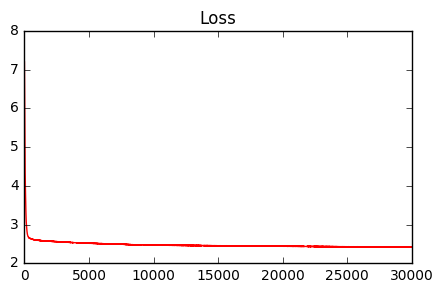

In [6]:
plt.figure(figsize=(5, 3))
plt.plot(losses, 'r-', alpha=1.0)
plt.title("Loss")

## PLOT SAMPLING RESULT

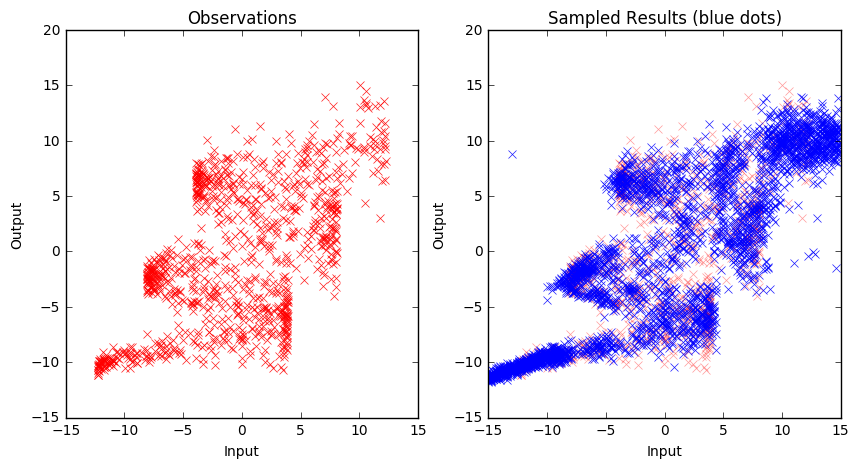

In [7]:
# SAMPLE
x_sample = np.float32(np.arange(-15,15,0.2)).reshape(-1, 1)
out_pi_test, out_sigma_test, out_mu_test, out_err_sigma_test \
    = sess.run([out_pi, out_sigma, out_mu, out_err_sigma]
               , feed_dict={x: x_sample})
y_test = sample_hgmm(out_pi_test, out_mu_test, out_sigma_test, out_err_sigma_test, KMIX)
f
# PLOT
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 5))
ax1.plot(x_data, y_data, 'rx', alpha=0.9)
ax1.set_title("Observations")
ax1.set_xlabel("Input")
ax1.set_ylabel("Output")

ax2.plot(x_data, y_data, 'rx', alpha=0.4)
ax2.plot(x_sample, y_test, 'bx', alpha=0.9)
ax2.set_title("Sampled Results (blue dots)")
ax2.set_xlabel("Input")
ax2.set_ylabel("Output")

## PLOT MEAN FUNCTIONS

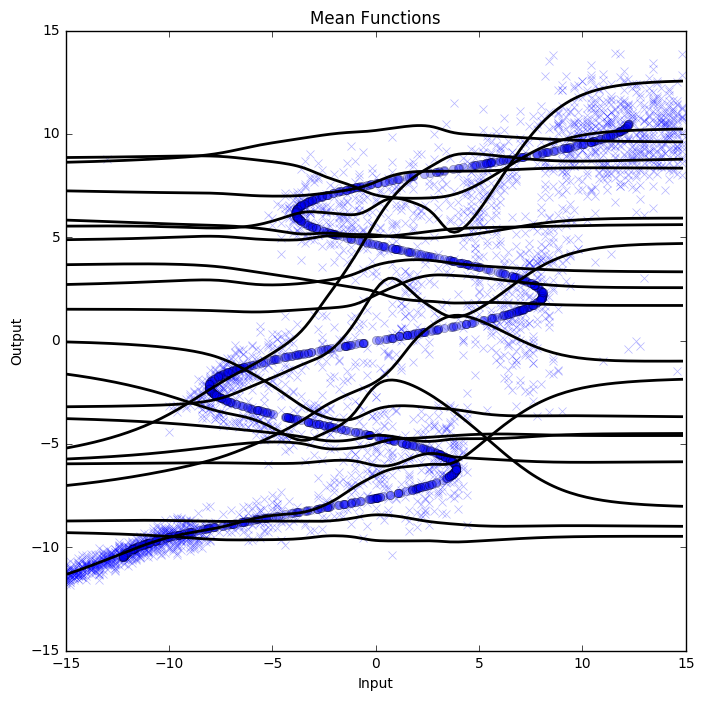

In [13]:
plt.figure(figsize=(8, 8))
p1=plt.plot(x_sample, y_test, 'bx', alpha=0.3, label="Sampling Result")
plt.plot(x_data, r_data, 'bo', alpha=0.3)
p2=plt.plot(x_sample, out_mu_test, 'k-', linewidth=2.0, label="Mean Functions")
plt.axis([-15, 15, -15, 15])
plt.title("Mean Functions")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()